# Exercise 8: Put all the concepts in Exercise 7 together

Skills:
* Apply all the concepts covered in Exercise 7 for a research question. Know when to use what concept.

References: 
* Exercise 7


### To Do

Narrow down the list of rail routes in CA to 3 groups. Use the SHN network to determine how much of the rail route runs near the SHN. We care only about rail routes that run entirely in CA (use stops to figure this out).

**Near** the interstate, US highway, or state highway is defined by being within a quarter mile. For this exercise, the distinction between interstate, US highway, and state highway is not important; treat any road that shows up in the dataset as "the SHN".

There are theoretically 3 groupings: 
* rail routes that are never within 0.25 miles of the SHN (>0.25
* rail routes with > 0 but less than half of its length near the SHN (0<x<0.5)
* rail routes with at least half of its length near the SHN(

Provide a table and a chart showing how many rail routes fall into each of the 3 groups by district.

Use a Markdown cell at the end to connect which geospatial concept was applied to which step of the process. The concepts that should be used are `projecting CRS`, `buffering`, `dissolve`, `clipping`, `spatial join`, `overlay`. 

---
---
## Notes
* all imported dfs are gdf 
* all with CRS 4326 (decimal degrees)
* all with active geometry col set to `geometry`
* all gdf filtered down to rail groups 0, 1 and 2
* geometry type for each gdf
    1. districts - polygon
    2. ca_highways - multi line string 
    3. routes - line string
    4. rail_routes - line string
    5. stops - point
    6. rail_stops - point
* check the plots of all the gdfs
* gdf not in CA
    1. routes (nationwide)
    2. rail routes (nationwide)
    3. stops 
    4. rail stops 
---
## Cleaning

COMPLETE project all gdf to `EPSG:2229` to get everything in feet and clip all gdf to California only

COMPLETE 1. dissolve districts map to be CA only.
    * `ca` - California polygon
        
COMPLETE 2. update `ca_highways` map to new CRS
    
COMPLETE 3. clip the other gdf to CA map. 
    * `ca_routes` - transit routes in CA
    * `ca_rail` - rail routes in CA for 0,1,2
    * `ca_stops` - transit stops in CA
    * `ca_rail_stops` - rail stops in CA for 0,1,2
        
COMPLETE 4. dissolve these ca maps to see what you get
    * `ca_routes_d`
    * `ca_rail_d`
    * `ca_stops_d`  
    * `ca_rail_stops_d`

5. check all new gdf against `gdf_check` function to ensure everything looks good
   
   
### prepare gdfs needed
1. COMPLETE buffer rail routes to 1320ft (.25miles)
    * `ca_rail_buffer`
2. dissolved all of those clipped gdf
    
        
---


## Breakdown of steps

    

### Use the SHN network to determine how much of the rail route runs near the SHN (<.25 miles)
   * need: 
       1. `ca_rail_buffer`
       2. `ca highway` 
       3. `district`

   * steps:
       1. create a GDF that combines the geomtry cols of the 3 gdf
       Or make a join of 2 gdf, then overlay the 3rd?
       overlay is for intersecting layers?
    
### rail routes that are never within 0.25 miles of the SHN
    * need:
        1. buffered route map
        

### rail routes with > 0 but less than half of its length near the SHN
    1. buffered rail route to < half_len

### rail routes with at least half of its length near the SHN
    1. buffered rail route to >= half_len
---
---

In [1]:
import geopandas as gpd
import intake
import pandas as pd

catalog = intake.open_catalog(
    "../_shared_utils/shared_utils/shared_data_catalog.yml")

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_305/1769798718.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling P

In [2]:
# Import data
districts = catalog.caltrans_districts.read()
ca_highways = catalog.state_highway_network.read()

rail_group = ['0', '1', '2']
routes = catalog.ca_transit_routes.read()
rail_routes = routes[routes.route_type.isin(rail_group)
                    ].reset_index(drop=True)

stops = catalog.ca_transit_stops.read()
rail_stops = stops[stops.route_type.isin(rail_group)
                  ].reset_index(drop=True)

---

## Geodataframe checks

---

In [3]:
#function test

def gdf_check(gdf):(
    print(f'Dataframe type is = {type(gdf)}'),
    print(f'GDF shape is = {gdf.shape}'),
    print(f'Active geometry col name is = {gdf.geometry.name}'),
    display(gdf.head()),
    display(gdf.plot()),
    display(gdf.crs)
    )

In [ ]:
#gdf of caltrans districts
#1 row for each districts, each district is a polygon

    #gdf_check(districts)

In [ ]:
#gdf of CA highways
#each row is a segment of a route, 

    #gdf_check(ca_highways)

In [ ]:
    #rail_group

In [ ]:
#gdf of all transit routes, nation wide?

    #gdf_check(routes)

In [ ]:
#gdf of all rail routes, for the sub rail-group

    #gdf_check(rail_routes)

In [ ]:
#gdf of all transit stops

    #gdf_check(stops)

In [ ]:
#gdf of all rail stops

    #gdf_check(rail_stops)

---

## Cleaning

---

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (1, 6)
Active geometry col name is = geometry


,geometry,OBJECTID,DISTRICT,Region,Shape__Area,Shape__Length
0,"POLYGON ((6105565.229 1946214.162, 6102975.223...",1,1,North,4.659910e+10,1.644579e+06


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

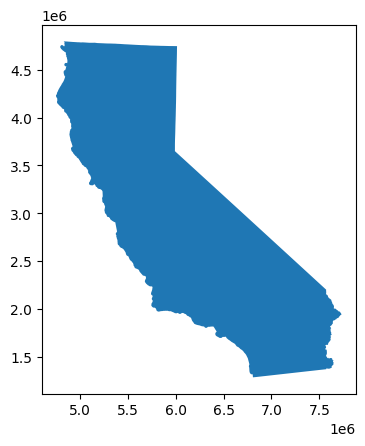

In [7]:
#setting crs and dissolving district map to one polygon
ca = districts.to_crs('EPSG:2229').dissolve()

gdf_check(ca)

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (1052, 6)
Active geometry col name is = geometry


,Route,County,District,RouteType,Direction,geometry
0,1,LA,7,State,NB,"MULTILINESTRING ((6518147.781 1746024.206, 651..."
1,1,LA,7,State,SB,"MULTILINESTRING ((6441469.111 1802436.519, 644..."
2,1,MEN,1,State,NB,"MULTILINESTRING ((4921021.829 3983216.471, 492..."
3,1,MEN,1,State,SB,"MULTILINESTRING ((4925456.388 3944268.826, 492..."
4,1,MON,5,State,NB,"MULTILINESTRING ((5458132.055 2852112.660, 545..."


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

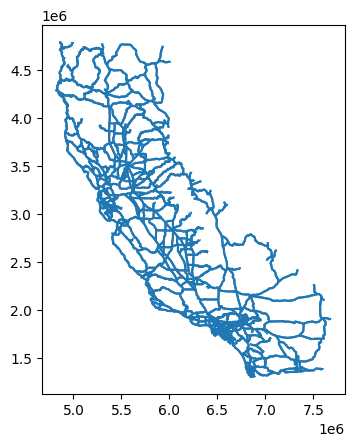

In [15]:
#update CRS for ca_highways

ca_highways = ca_highways.to_crs('EPSG:2229')

gdf_check(ca_highways)

In [10]:
#test to combine clipping and CRS
#TEST WORKS! apply same to other gdfs

ca_routes = routes.to_crs('EPSG:2229').clip(ca)

In [11]:
ca_rail = rail_routes.to_crs('EPSG:2229').clip(ca)

In [12]:
ca_stops = stops.to_crs('EPSG:2229').clip(ca)

In [13]:
ca_rail_stops = rail_stops.to_crs('EPSG:2229').clip(ca)

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (6516, 10)
Active geometry col name is = geometry


,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry
22,recKsb5FnJy70up78,Amtrak,36930,2,Sunset Limited,269,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((7602807.693 1377257.623, 760..."
23,recKsb5FnJy70up78,Amtrak,36930,2,Sunset Limited,271,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((6489947.165 1842910.544, 649..."
2848,recLW3EuIHTqTjdds,Greyhound,US1001,3,Phoenix - Houston,c37251529f04a05b2574ce6daa6843b4,1,aHR0cDovL2d0ZnMuZ2lzLmZsaXgudGVjaC9ndGZzX2dlbm...,http://gtfs.gis.flix.tech/gtfs_generic_us.zip,"MULTILINESTRING ((7617963.358 1696760.580, 761..."
2847,recLW3EuIHTqTjdds,Greyhound,US1001,3,Phoenix - Houston,a2bb22ec6b8d212187fa35489ed076a0,1,aHR0cDovL2d0ZnMuZ2lzLmZsaXgudGVjaC9ndGZzX2dlbm...,http://gtfs.gis.flix.tech/gtfs_generic_us.zip,"MULTILINESTRING ((6491323.819 1842508.112, 649..."
5840,rech5YtfjpQvVIBAF,Flagship Cruises and Events Inc.,894,3,Morena/Campo - El Cajon,S2_894_2_33,1,aHR0cHM6Ly93d3cuc2RtdHMuY29tL2dvb2dsZV90cmFuc2...,https://www.sdmts.com/google_transit_files/goo...,"MULTILINESTRING ((6892035.793 1361216.709, 689..."


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

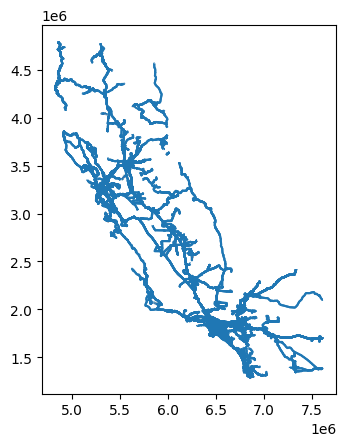

In [14]:
# try GDF check on clipped gdf
gdf_check(ca_routes)


Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (145, 10)
Active geometry col name is = geometry


,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry
167,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805EB_190513,89,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6467811.689 1844958.751, 6467905.8..."
168,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805WB_190513,88,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6491361.499 1839175.379, 6491362.1..."
161,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,802,1,Metro B-Line,802EB_190513,91,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6447247.135 1884754.987, 6447751.8..."
162,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,802,1,Metro B-Line,802WB_190513,91,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6491361.510 1839175.378, 6491362.2..."
147,recC5CT95EufmQCXr,Santa Clara Valley Transportation Authority,BlueS,0,"Due to construction, portions of Light Rail re...",110754,2,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,https://api.511.org/transit/datafeeds?api_key=...,"LINESTRING (5426631.150 3064619.004, 5427824.4..."


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

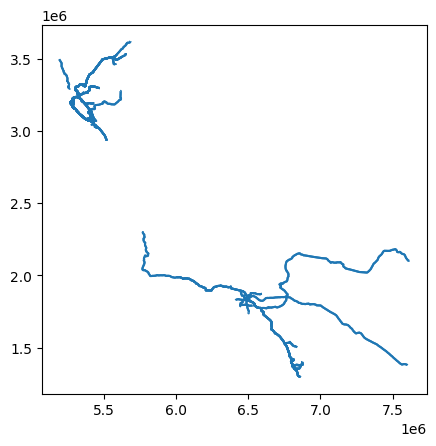

In [16]:
gdf_check(ca_rail)

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (116559, 9)
Active geometry col name is = geometry


,org_id,agency,route_id,route_type,stop_id,stop_name,base64_url,uri,geometry
102103,rech5YtfjpQvVIBAF,Flagship Cruises and Events Inc.,950,3,88963,Otay Mesa Transit Center,aHR0cHM6Ly93d3cuc2RtdHMuY29tL2dvb2dsZV90cmFuc2...,https://www.sdmts.com/google_transit_files/goo...,POINT (6888566.919 1297344.013)
101162,rech5YtfjpQvVIBAF,Flagship Cruises and Events Inc.,909,3,60529,Via De La Amistad & Roll Dr,aHR0cHM6Ly93d3cuc2RtdHMuY29tL2dvb2dsZV90cmFuc2...,https://www.sdmts.com/google_transit_files/goo...,POINT (6889498.731 1297378.021)
101173,rech5YtfjpQvVIBAF,Flagship Cruises and Events Inc.,909,3,88964,Otay Mesa Transit Center,aHR0cHM6Ly93d3cuc2RtdHMuY29tL2dvb2dsZV90cmFuc2...,https://www.sdmts.com/google_transit_files/goo...,POINT (6888510.894 1297383.680)
101065,rech5YtfjpQvVIBAF,Flagship Cruises and Events Inc.,905,3,60523,Siempre Viva Rd & Customhouse Plaza,aHR0cHM6Ly93d3cuc2RtdHMuY29tL2dvb2dsZV90cmFuc2...,https://www.sdmts.com/google_transit_files/goo...,POINT (6886743.534 1297385.771)
101064,rech5YtfjpQvVIBAF,Flagship Cruises and Events Inc.,905,3,60522,Siempre Viva Rd & Drucker Ln,aHR0cHM6Ly93d3cuc2RtdHMuY29tL2dvb2dsZV90cmFuc2...,https://www.sdmts.com/google_transit_files/goo...,POINT (6885821.738 1297391.965)


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

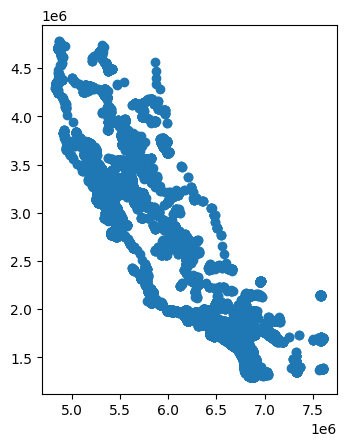

In [17]:
gdf_check(ca_stops)

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (1211, 9)
Active geometry col name is = geometry


,org_id,agency,route_id,route_type,stop_id,stop_name,base64_url,uri,geometry
1537,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,801,0,80102,Pacific Ave Station,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,POINT (6502796.262 1739558.050)
1541,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,801,0,80108,Wardlow Station,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,POINT (6502103.679 1756884.927)
1542,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,801,0,80109,Del Amo Station,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,POINT (6497591.225 1767213.933)
1543,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,801,0,80110,Artesia Station,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,POINT (6494125.943 1777360.375)
1544,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,801,0,80111,Compton Station,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,POINT (6493613.327 1785152.416)


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

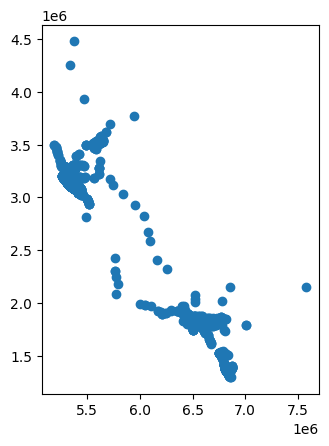

In [18]:
gdf_check(ca_rail_stops)

---

Dissolve check

---


In [ ]:

#Dissolving one by one

ca_highway_d = ca_highways.dissolve()


In [ ]:
#update to ca_routes (clipped)

routes_d= ca_routes.dissolve()


In [ ]:
#update to clipped rail routes
rail_d= ca_rail.dissolve()

In [ ]:
#update to clipped stops route

stops_d = ca_stops.dissolve()

In [ ]:
#update to clipped rail stops routes
rail_stops_d = rca_rail_stops.dissolve()

In [ ]:
#### TRY DISSOLVING THE ABOVE!!!
### THEN OVERLAY ON STUFF

---

analysis

---

In [ ]:
# buffering the rail route to 1320 ft.

ca_rail_buffer = ca_rail.assign(g_buffer = ca_rail.geometry.buffer(1320))

display(ca_rail_buffer.head())
display(ca_rail_buffer.geometry.name)
ca_rail_buffer.plot()

In [ ]:
ca_highways.plot()

In [ ]:
# add new col for length and half-legth of rail route from ca_rail
# may need this later to update buffer
ca_rail = ca_rail.assign(length = ca_rail.geometry.length)
ca_rail.head()

In [ ]:
#Test of overlay districts and ca_rail_buffer 

overlay = gpd.overlay(
    districts2229,
    ca_rail_buffer.set_geometry('g_buffer'),
    how = 'difference',
    keep_geom_type=True
)


In [ ]:
districts2229

In [ ]:
ca_rail_buffer.head(2)

In [ ]:
#got something when i overlay districts and rail routes!

#inspect what happens to the geometry column after overlaying. are there any duplicate rows? if so, why.
#are the routes the same after the overlay?
#remember to use length, and % of something. 
# 
display(overlay)
display(overlay.geometry.name)
overlay.plot()

In [ ]:
import matplotlib.pyplot as plt



In [ ]:
#try dissolving highways2999.
#overlay changes geometry values.
#try overlay to get length of rail route that interects
#try to find difference of overlayed geomety from SHN
highways2229

In [ ]:
#found this via youtube tutorial.
#maps the highways and rail routes over distrcts

fig, ax = plt.subplots(figsize = (10,8))
highways2229.plot(ax = ax, edgecolor = 'black')
ca_rail_buffer.plot(ax= ax, edgecolor = 'white')
districts2229.plot(ax = ax)